# **Predicting Depression Risk Using NHANES Behavioral and Clinical Data: A Machine Learning Approach**

## *Matthew Maslow*

In [3]:
# Core Libraries
import os
import pandas as pd
import numpy as np

# File Reading
import pyreadstat

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Modeling
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, validation_curve

# Visualization
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Explainability
import shap

# Explainability
import shap

# Load in Data

In [5]:
base_folder = "/Users/matthewmaslow/desktop/DS-596-Special Topics Medical Science/Final Project"
data_folder = os.path.join(base_folder, "data")
output_folder = os.path.join(base_folder, "DataCSV")

selected_columns = {
    "mhDepressionScreener_nhanes.xpt": ["SEQN", "DPQ020", "DPQ060", "DPQ090"],
    "demographics_nhanes.xpt": ["SEQN", "RIAGENDR", "RIDAGEYR", "RIDRETH3", "DMDEDUC2", "DMDMARTZ", "INDFMPIR"],
    "income_nhanes.xpt": ["SEQN", "INDFMMPI", "INDFMMPC", "INQ300", "IND310"],
    "sleepDisorders_nhanes.xpt": ["SEQN", "SLD012", "SLD013"],
    "smokingBehavior_nhanes.xpt": ["SEQN", "SMQ020", "SMQ040", "SMD650"],
    "alcoholUse_nhanes.xpt": ["SEQN", "ALQ111", "ALQ121", "ALQ270"],
    "physicalActivity_nhanes.xpt": ["SEQN", "PAD800", "PAD820", "PAD680"],
    "VID_L_nhanes.xpt": ["SEQN", "LBXVIDMS"],
    "GHB_L_nhanes.xpt": ["SEQN", "LBXGH"],
    "HSCRP_L_nhanes.xpt": ["SEQN", "LBXHSCRP"]
}

def load_selected_columns(file_path, columns):
    try:
        df, _ = pyreadstat.read_xport(file_path, usecols=columns)
        print(f"Loaded with pyreadstat: {os.path.basename(file_path)}")
    except Exception:
        df = pd.read_sas(file_path, format='xport', encoding='latin1')
        df = df[columns]
        print(f"Fallback to pandas: {os.path.basename(file_path)}")
    return df

merged_df = None
for file_name, cols in selected_columns.items():
    path = os.path.join(data_folder, file_name)
    df = load_selected_columns(path, cols)
    merged_df = df if merged_df is None else pd.merge(merged_df, df, on="SEQN", how="left")

os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, "nhanes_cleaned_merged.csv")
merged_df.to_csv(output_path, index=False)

print(f"\nMerged file saved to: {output_path}")
print(f"Final shape: {merged_df.shape}")

Loaded with pyreadstat: mhDepressionScreener_nhanes.xpt
Loaded with pyreadstat: demographics_nhanes.xpt
Loaded with pyreadstat: income_nhanes.xpt
Loaded with pyreadstat: sleepDisorders_nhanes.xpt
Loaded with pyreadstat: smokingBehavior_nhanes.xpt
Loaded with pyreadstat: alcoholUse_nhanes.xpt
Loaded with pyreadstat: physicalActivity_nhanes.xpt
Loaded with pyreadstat: VID_L_nhanes.xpt
Loaded with pyreadstat: GHB_L_nhanes.xpt
Loaded with pyreadstat: HSCRP_L_nhanes.xpt

Merged file saved to: /Users/matthewmaslow/desktop/DS-596-Special Topics Medical Science/Final Project/DataCSV/nhanes_cleaned_merged.csv
Final shape: (6337, 28)


In [6]:
df = pd.read_csv(os.path.join(output_folder, "nhanes_cleaned_merged.csv"))

print(df.dtypes)
print(df.isnull().sum())
print(df.shape)
print(df.head())

SEQN        float64
DPQ020      float64
DPQ060      float64
DPQ090      float64
RIAGENDR    float64
RIDAGEYR    float64
RIDRETH3    float64
DMDEDUC2    float64
DMDMARTZ    float64
INDFMPIR    float64
INDFMMPI    float64
INDFMMPC    float64
INQ300      float64
IND310      float64
SLD012      float64
SLD013      float64
SMQ020      float64
SMQ040      float64
SMD650      float64
ALQ111      float64
ALQ121      float64
ALQ270      float64
PAD800      float64
PAD820      float64
PAD680      float64
LBXVIDMS    float64
LBXGH       float64
LBXHSCRP    float64
dtype: object
SEQN           0
DPQ020       819
DPQ060       827
DPQ090       831
RIAGENDR       0
RIDAGEYR       0
RIDRETH3       0
DMDEDUC2     273
DMDMARTZ     274
INDFMPIR     831
INDFMMPI    1286
INDFMMPC     520
INQ300       517
IND310      3476
SLD012        65
SLD013        67
SMQ020         2
SMQ040      3819
SMD650      5425
ALQ111       856
ALQ121      1415
ALQ270      3971
PAD800      1306
PAD820      3460
PAD680         6
L

# Data Preparation

In [8]:
df = df.dropna(subset=["DPQ020", "DPQ060", "DPQ090"])

In [9]:
df = df.drop(columns=["SMD650", "SMQ040", "ALQ270", "PAD820", "IND310"])

In [10]:
num_cols = df.select_dtypes(include="number").columns.tolist()
num_cols = [col for col in num_cols if col not in ["SEQN", "DPQ020", "DPQ060", "DPQ090"]]

imputer = SimpleImputer(strategy="median")
df[num_cols] = imputer.fit_transform(df[num_cols])

In [11]:
invalid_vals = [7, 9, 77, 99, 777, 7777, 999, 9999]

df = df[~df.isin(invalid_vals).any(axis=1)]

df.reset_index(drop=True, inplace=True)

In [12]:
df['DPQ020_binary'] = df['DPQ020'].apply(lambda x: 0 if x == 0 else 1)
df['DPQ060_binary'] = df['DPQ060'].apply(lambda x: 0 if x == 0 else 1)

# Model Training

### DPQ020 – Feeling down, depressed, or hopeless

In [15]:
classes = np.array(sorted(df["DPQ020"].unique()))
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=df["DPQ020"])
class_weights = dict(zip(classes, class_weights_array))
print(class_weights_array)

[0.37325508 1.07149362 4.74395161 5.65625   ]


Logistic Regression Results (DPQ020_binary)
              precision    recall  f1-score   support

           0       0.79      0.59      0.68       315
           1       0.45      0.69      0.55       156

    accuracy                           0.62       471
   macro avg       0.62      0.64      0.61       471
weighted avg       0.68      0.62      0.63       471

[[186 129]
 [ 49 107]]


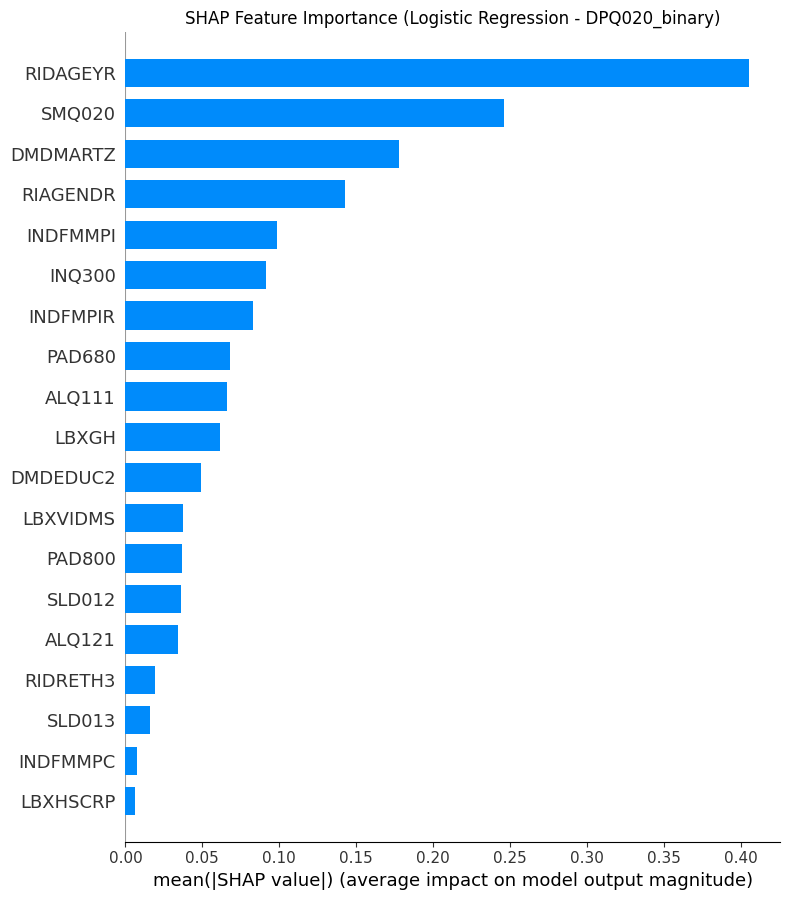

XGBoost Results (DPQ020_binary)
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       315
           1       0.49      0.38      0.43       156

    accuracy                           0.66       471
   macro avg       0.61      0.59      0.60       471
weighted avg       0.65      0.66      0.65       471

[[252  63]
 [ 96  60]]


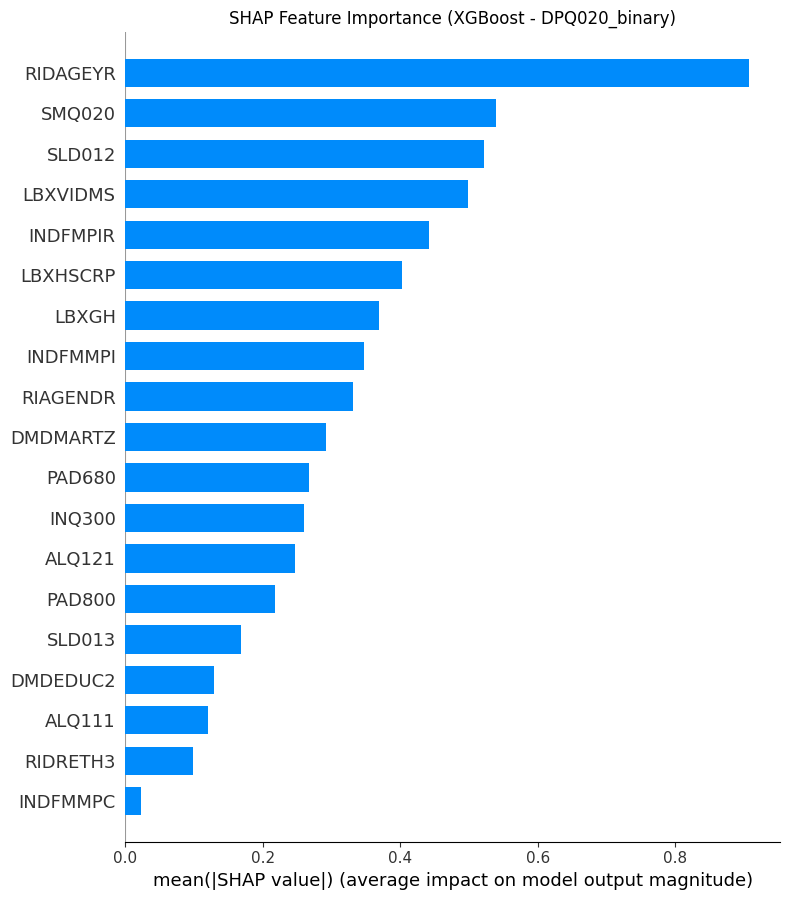

In [16]:
X = df.drop(columns=["SEQN", "DPQ020", "DPQ060", "DPQ090", "DPQ020_binary", "DPQ060_binary"])
y = df["DPQ020_binary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight=class_weights)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("Logistic Regression Results (DPQ020_binary)")
print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))

explainer_log = shap.Explainer(log_reg, X_train_scaled, feature_names=X.columns)
shap_values_log = explainer_log(X_test_scaled)
plt.figure()
shap.summary_plot(shap_values_log, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Logistic Regression - DPQ020_binary)")
plt.tight_layout()
plt.show()

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=10,
    scale_pos_weight=class_weights[1] / class_weights[0]
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Results (DPQ020_binary)")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

explainer_xgb = shap.Explainer(xgb)
shap_values_xgb = explainer_xgb(X_test)
plt.figure()
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (XGBoost - DPQ020_binary)")
plt.tight_layout()
plt.show()

#### Validation

In [18]:
log_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='f1')
print("Logistic Regression Cross-Validated F1 Score (mean ± std):", log_scores.mean(), "+/-", log_scores.std())

xgb_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1')
print("XGBoost Cross-Validated F1 Score (mean ± std):", xgb_scores.mean(), "+/-", xgb_scores.std())

Logistic Regression Cross-Validated F1 Score (mean ± std): 0.5348596434072617 +/- 0.02329572659756699
XGBoost Cross-Validated F1 Score (mean ± std): 0.3990104656138901 +/- 0.018777327363326997


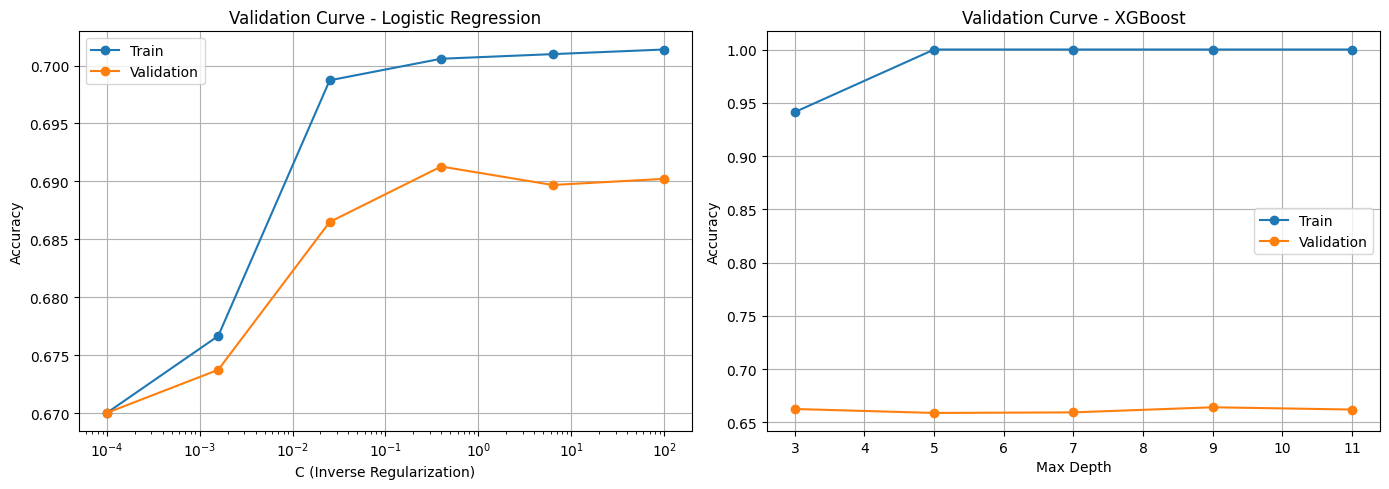

In [19]:
param_range_logreg = np.logspace(-4, 2, 6)
train_scores_log, test_scores_log = validation_curve(
    LogisticRegression(max_iter=1000),
    X_train_scaled,
    y_train,
    param_name='C',
    param_range=param_range_logreg,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

param_range_xgb = [3, 5, 7, 9, 11]
train_scores_xgb, test_scores_xgb = validation_curve(
    XGBClassifier(learning_rate=0.05, n_estimators=1000, eval_metric='logloss'),
    X_train,
    y_train,
    param_name='max_depth',
    param_range=param_range_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(param_range_logreg, train_scores_log.mean(axis=1), label="Train", marker='o')
axs[0].plot(param_range_logreg, test_scores_log.mean(axis=1), label="Validation", marker='o')
axs[0].set_xscale('log')
axs[0].set_xlabel("C (Inverse Regularization)")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Validation Curve - Logistic Regression")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(param_range_xgb, train_scores_xgb.mean(axis=1), label="Train", marker='o')
axs[1].plot(param_range_xgb, test_scores_xgb.mean(axis=1), label="Validation", marker='o')
axs[1].set_xlabel("Max Depth")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Validation Curve - XGBoost")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### DPQ060_binary - Feeling bad about yourself

In [21]:
classes = np.array(sorted(df["DPQ060"].unique()))
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=df["DPQ060"])
class_weights = dict(zip(classes, class_weights_array))
print(class_weights_array)

[0.34200581 1.34919725 5.29954955 6.84011628]


Logistic Regression Results (DPQ060_binary)
              precision    recall  f1-score   support

           0       0.84      0.66      0.74       344
           1       0.41      0.65      0.50       127

    accuracy                           0.66       471
   macro avg       0.62      0.65      0.62       471
weighted avg       0.72      0.66      0.68       471

[[228 116]
 [ 45  82]]


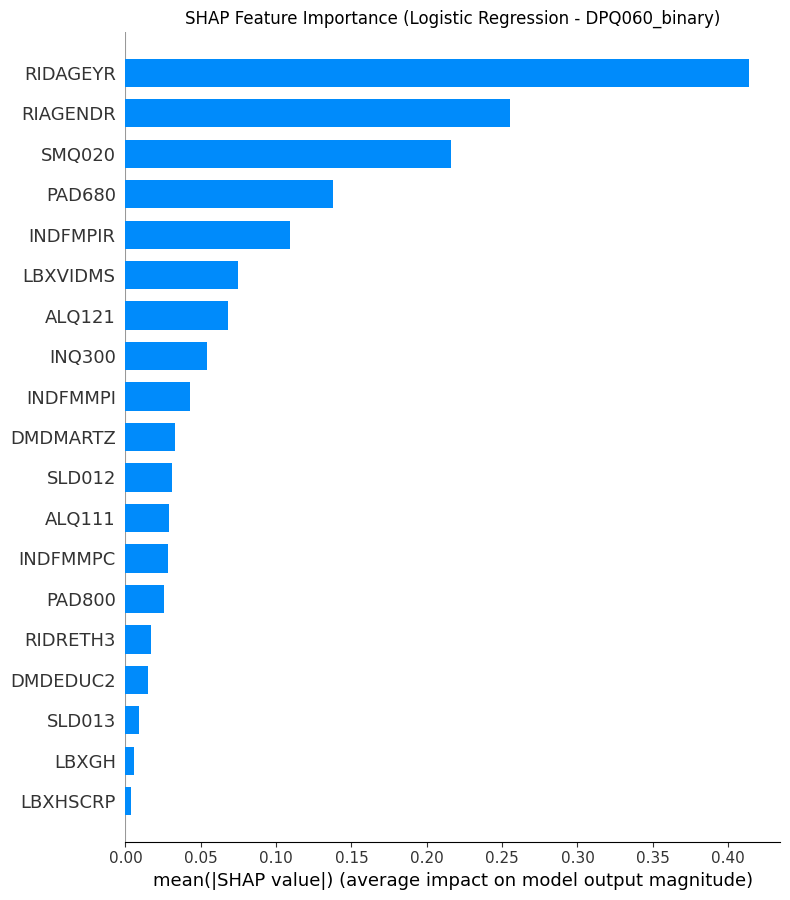

XGBoost Results (DPQ060_binary)
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       344
           1       0.39      0.27      0.32       127

    accuracy                           0.69       471
   macro avg       0.57      0.56      0.56       471
weighted avg       0.66      0.69      0.67       471

[[290  54]
 [ 93  34]]


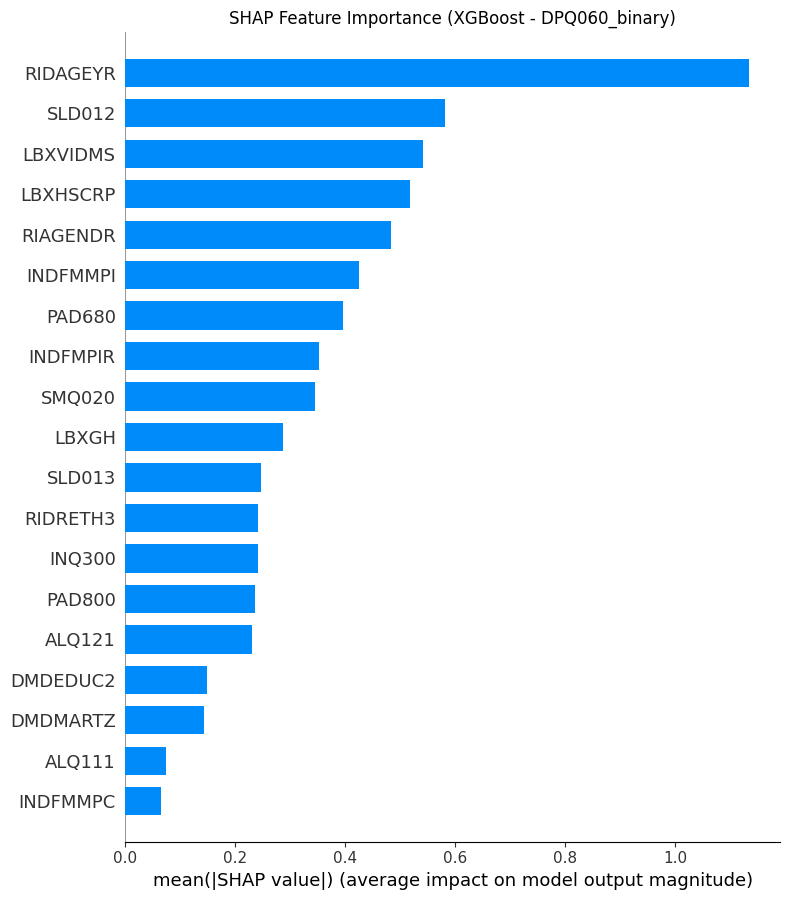

In [22]:
X = df.drop(columns=["SEQN", "DPQ020", "DPQ060", "DPQ090", "DPQ020_binary", "DPQ060_binary"])
y = df["DPQ060_binary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight=class_weights)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("Logistic Regression Results (DPQ060_binary)")
print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))

explainer_log = shap.Explainer(log_reg, X_train_scaled, feature_names=X.columns)
shap_values_log = explainer_log(X_test_scaled)
plt.figure()
shap.summary_plot(shap_values_log, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Logistic Regression - DPQ060_binary)")
plt.tight_layout()
plt.show()

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=10,
    scale_pos_weight=class_weights[1] / class_weights[0]
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Results (DPQ060_binary)")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

explainer_xgb = shap.Explainer(xgb)
shap_values_xgb = explainer_xgb(X_test)
plt.figure()
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (XGBoost - DPQ060_binary)")
plt.tight_layout()
plt.show()

#### Validation

In [24]:
log_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='f1')
print("Logistic Regression Cross-Validated F1 Score (mean ± std):", log_scores.mean(), "+/-", log_scores.std())

xgb_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1')
print("XGBoost Cross-Validated F1 Score (mean ± std):", xgb_scores.mean(), "+/-", xgb_scores.std())

Logistic Regression Cross-Validated F1 Score (mean ± std): 0.4679322508665883 +/- 0.018278261622465264
XGBoost Cross-Validated F1 Score (mean ± std): 0.34185807295920434 +/- 0.010802380228495638


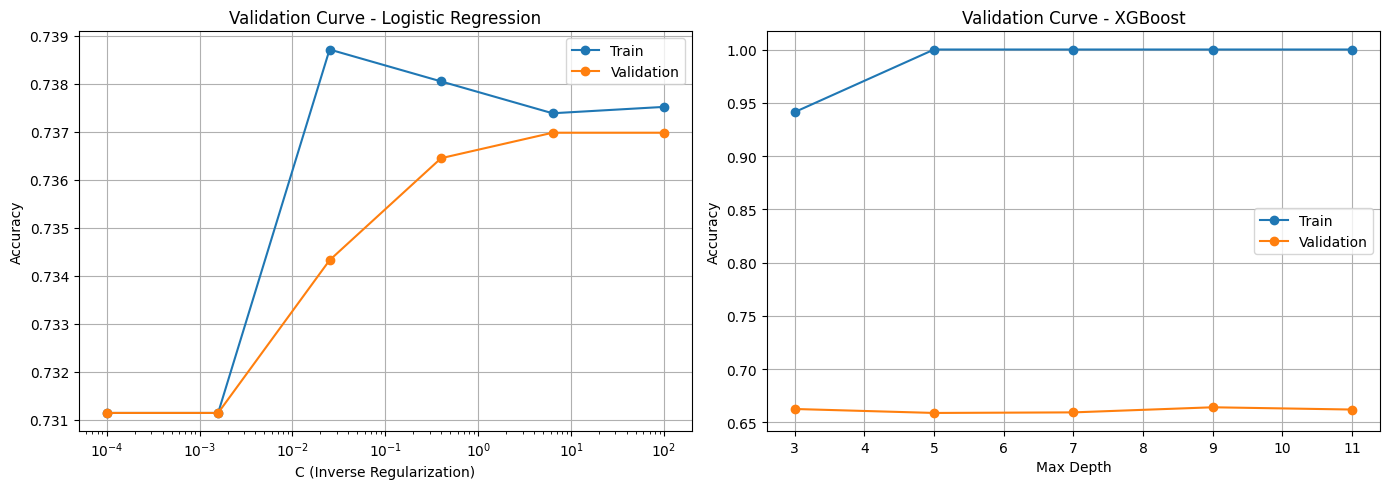

In [25]:
param_range_logreg = np.logspace(-4, 2, 6)
train_scores_log, test_scores_log = validation_curve(
    LogisticRegression(max_iter=1000),
    X_train_scaled,
    y_train,
    param_name='C',
    param_range=param_range_logreg,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

param_range_xgb = [3, 5, 7, 9, 11]
xgb = XGBClassifier(
    learning_rate=0.05,
    n_estimators= 1000,   
    early_stopping_rounds=10,
    max_depth=10,        
    use_label_encoder=False,
    eval_metric='logloss'
)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(param_range_logreg, train_scores_log.mean(axis=1), label="Train", marker='o')
axs[0].plot(param_range_logreg, test_scores_log.mean(axis=1), label="Validation", marker='o')
axs[0].set_xscale('log')
axs[0].set_xlabel("C (Inverse Regularization)")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Validation Curve - Logistic Regression")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(param_range_xgb, train_scores_xgb.mean(axis=1), label="Train", marker='o')
axs[1].plot(param_range_xgb, test_scores_xgb.mean(axis=1), label="Validation", marker='o')
axs[1].set_xlabel("Max Depth")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Validation Curve - XGBoost")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Imbalanced Learning (SMOTE)

In [27]:
def train_smote_models(X, y, label):
    print(f"\n============================")
    print(f"Running Models for {label}")
    print(f"============================")

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

    log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, C=1.0, class_weight=None)
    log_reg.fit(X_train_res, y_train_res)
    y_pred_log = log_reg.predict(X_test_scaled)

    print(f"\nLogistic Regression Results – {label}")
    print(classification_report(y_test, y_pred_log))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

    xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=10
    )
    xgb.fit(X_train_res, y_train_res)
    y_pred_xgb = xgb.predict(X_test_scaled)

    print(f"\nXGBoost Results – {label}")
    print(classification_report(y_test, y_pred_xgb))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

    explainer_xgb = shap.Explainer(xgb)
    shap_values_xgb = explainer_xgb(X_test)
    plt.figure()
    shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance (XGBoost – {label})")
    plt.tight_layout()
    plt.show()


    # Validation Curves
    param_range_logreg = np.logspace(-4, 2, 6)
    train_scores_log, test_scores_log = validation_curve(
        LogisticRegression(max_iter=1000),
        X_train_res,
        y_train_res,
        param_name='C',
        param_range=param_range_logreg,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    param_range_xgb = [3, 5, 7, 9, 11]
    train_scores_xgb, test_scores_xgb = validation_curve(
        XGBClassifier(learning_rate=0.05, n_estimators=1000, eval_metric='logloss'),
        X_train_res,
        y_train_res,
        param_name='max_depth',
        param_range=param_range_xgb,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(param_range_logreg, train_scores_log.mean(axis=1), label="Train", marker='o')
    axs[0].plot(param_range_logreg, test_scores_log.mean(axis=1), label="Validation", marker='o')
    axs[0].set_xscale('log')
    axs[0].set_xlabel("C (Inverse Regularization)")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_title(f"Validation Curve – Logistic ({label})")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(param_range_xgb, train_scores_xgb.mean(axis=1), label="Train", marker='o')
    axs[1].plot(param_range_xgb, test_scores_xgb.mean(axis=1), label="Validation", marker='o')
    axs[1].set_xlabel("Max Depth")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title(f"Validation Curve – XGBoost ({label})")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


Running Models for DPQ020_binary

Logistic Regression Results – DPQ020_binary
              precision    recall  f1-score   support

           0       0.78      0.58      0.67       315
           1       0.44      0.66      0.53       156

    accuracy                           0.61       471
   macro avg       0.61      0.62      0.60       471
weighted avg       0.67      0.61      0.62       471

Confusion Matrix:
 [[184 131]
 [ 53 103]]

XGBoost Results – DPQ020_binary
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       315
           1       0.41      0.32      0.36       156

    accuracy                           0.62       471
   macro avg       0.55      0.54      0.54       471
weighted avg       0.60      0.62      0.61       471

Confusion Matrix:
 [[242  73]
 [106  50]]


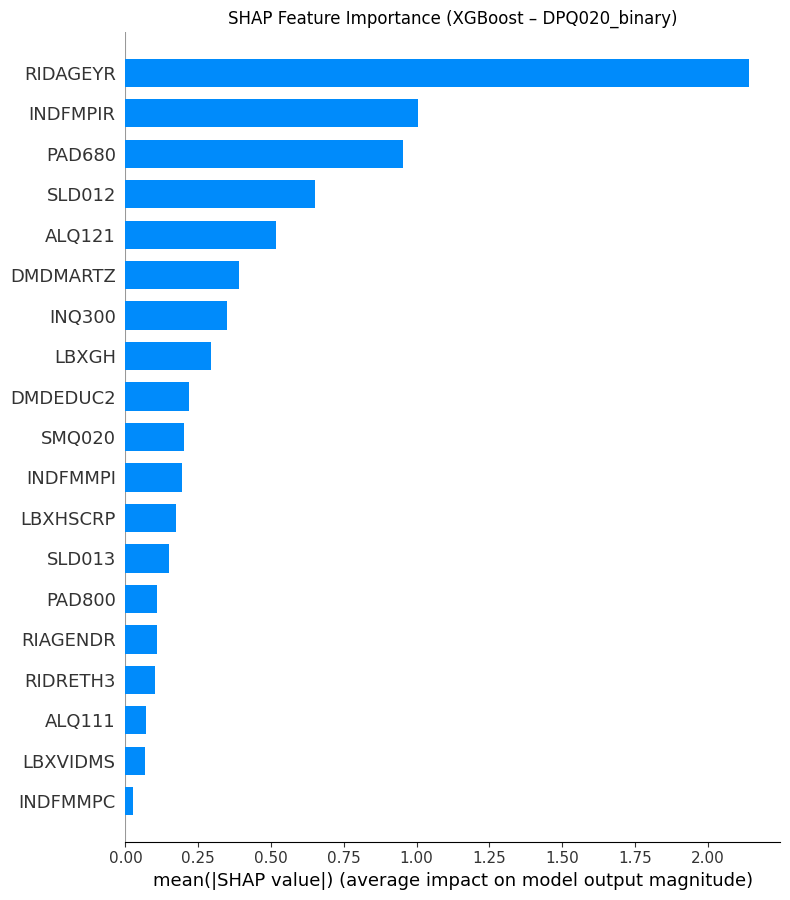

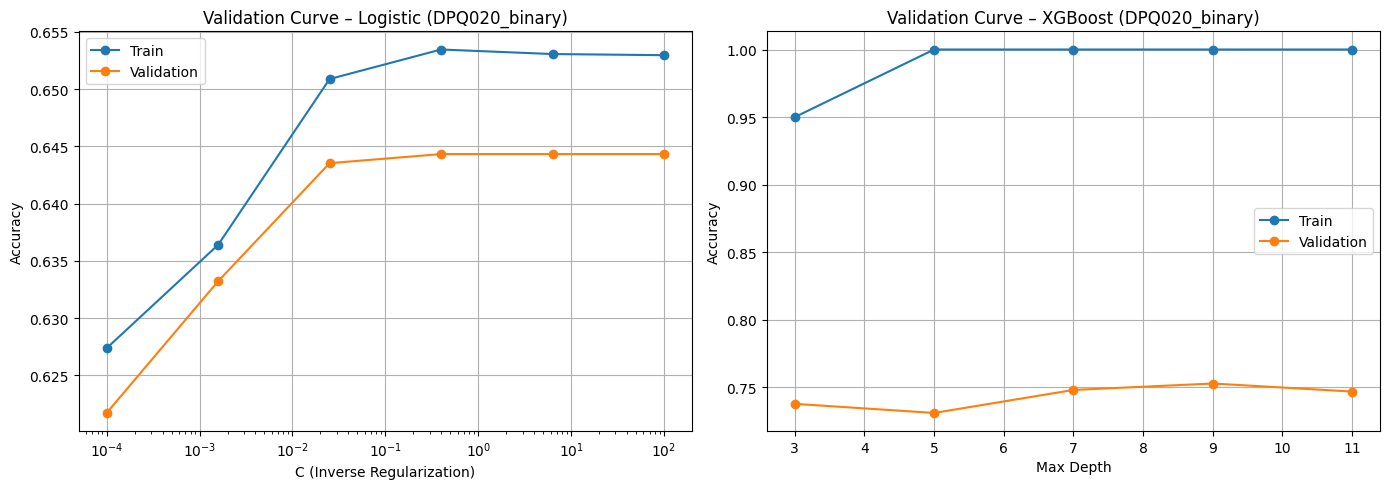


Running Models for DPQ060_binary

Logistic Regression Results – DPQ060_binary
              precision    recall  f1-score   support

           0       0.84      0.65      0.73       344
           1       0.41      0.65      0.50       127

    accuracy                           0.65       471
   macro avg       0.62      0.65      0.62       471
weighted avg       0.72      0.65      0.67       471

Confusion Matrix:
 [[223 121]
 [ 44  83]]

XGBoost Results – DPQ060_binary
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       344
           1       0.38      0.28      0.33       127

    accuracy                           0.68       471
   macro avg       0.57      0.56      0.56       471
weighted avg       0.66      0.68      0.67       471

Confusion Matrix:
 [[286  58]
 [ 91  36]]


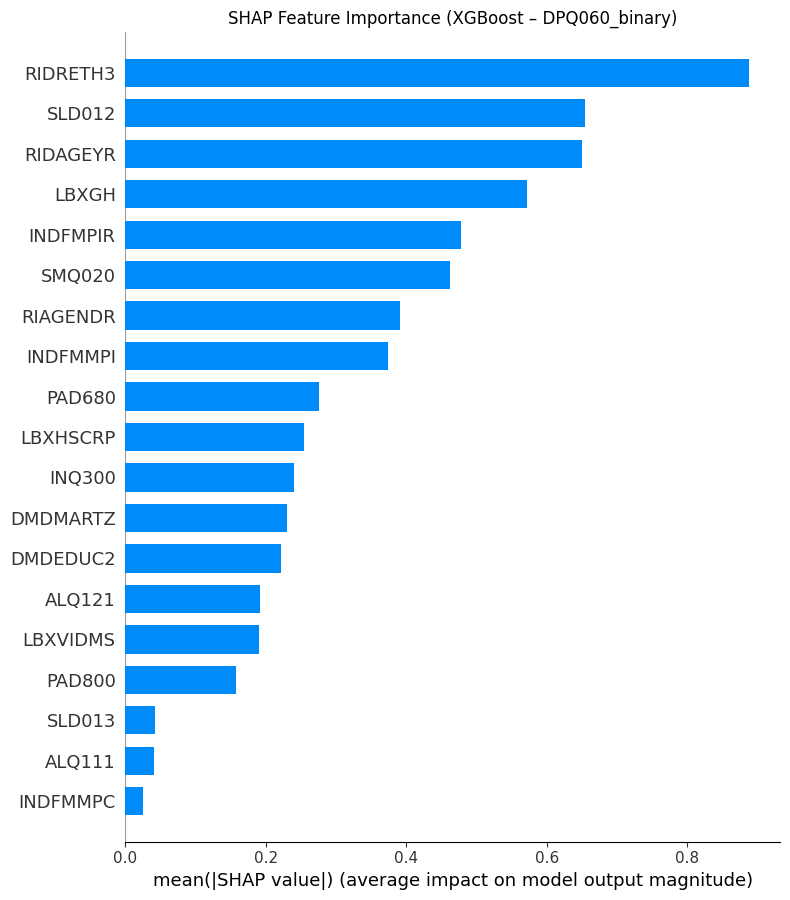

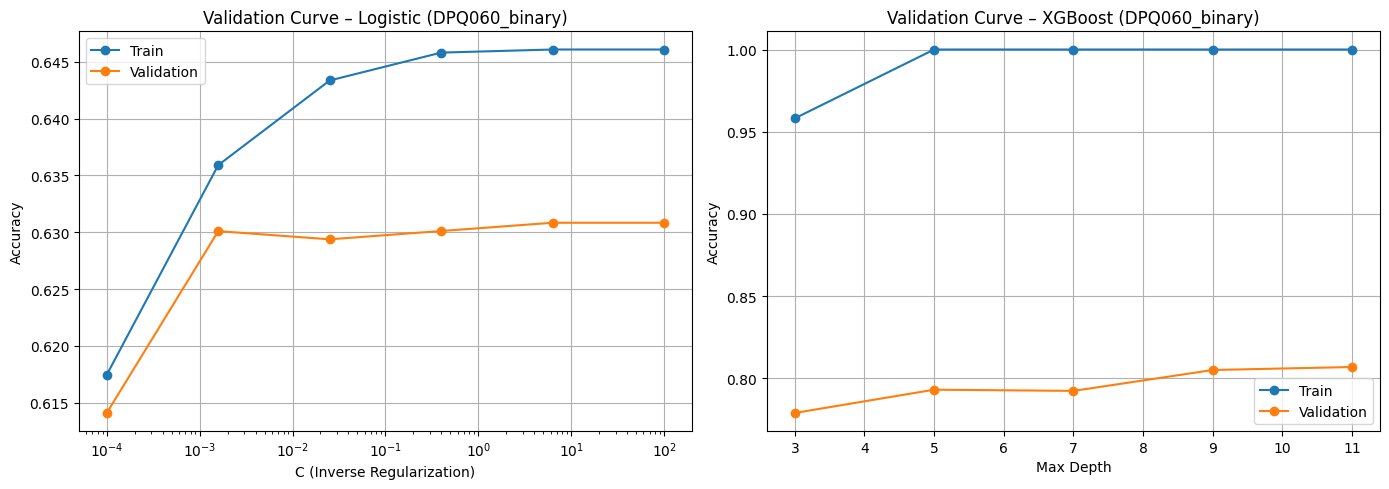

In [28]:
X_020 = df.drop(columns=["SEQN", "DPQ020", "DPQ060", "DPQ090", "DPQ020_binary", "DPQ060_binary"])
y_020 = df["DPQ020_binary"]
train_smote_models(X_020, y_020, "DPQ020_binary")

X_060 = df.drop(columns=["SEQN", "DPQ020", "DPQ060", "DPQ090", "DPQ020_binary", "DPQ060_binary"])
y_060 = df["DPQ060_binary"]
train_smote_models(X_060, y_060, "DPQ060_binary")